In [1]:
import os
import numpy
from scipy import integrate, linalg
from matplotlib import pyplot

# integrate plots into the notebook
%matplotlib inline

In [2]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center-point, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is located on the upper or lower surface of the geometry.
        Initializes the source-strength, tangential velocity, and pressure coefficient
        of the panel to zero.
        
        Parameters
        ---------_
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya # panel starting-point
        self.xb, self.yb = xb, yb # panel ending-point
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         # panel center
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2) # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper' # upper surface
        else:
            self.loc = 'lower' # lower surface
        
        self.sigma = 0.0 # source strength
        self.gamma = 0.0
        self.vt = 0.0    # tangential velocity
        self.cp = 0.0    # pressure coefficient

In [3]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (in degrees).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default 0.0.
        """
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 # degrees to radians

In [4]:
def integral(x, y, panel, dxdk, dydk):
    """
    Evaluates the contribution from a panel at a given point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.
    
    Returns
    -------
    Contribution from the panel at a given point (x, y).
    """
    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [5]:
def source_contribution_normal(panels):
    """
    Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Source contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                numpy.cos(panel_i.beta),
                                                numpy.sin(panel_i.beta))
    return A

In [6]:
def vortex_contribution_normal(panels):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 numpy.sin(panel_i.beta),
                                                 -numpy.cos(panel_i.beta))
    return A

In [7]:
def kutta_condition(A_source, B_vortex):
    """
    Builds the Kutta condition array.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    b: 1D Numpy array of floats
        The left-hand side of the Kutta-condition equation.
    """
    b = numpy.empty(A_source.shape[0]+1, dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    b[-1] = - numpy.sum(A_source[0, :] + A_source[-1, :])
    return b

In [8]:
def build_singularity_matrix(A_source, B_vortex):
    """
    Builds the left-hand side matrix of the system
    arising from source and vortex contributions.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    A:  2D Numpy array of floats
        Matrix of the linear system.
    """
    A = numpy.empty((A_source.shape[0]+1, A_source.shape[1]+1), dtype=float)
    # source contribution matrix
    A[:-1, :-1] = A_source
    # vortex contribution array
    A[:-1, -1] = numpy.sum(B_vortex, axis=1)
    # Kutta condition array
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A

In [9]:
def build_freestream_rhs(panels, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = numpy.empty(panels.size+1,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[0].beta)
                               +numpy.sin(freestream.alpha-panels[-1].beta) )
    return b

In [10]:
def compute_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [11]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    A = numpy.empty((panels.size, panels.size+1), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-1] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -1] = -numpy.sum(A_source, axis=1)
    # freestream contribution
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta 
                                    for panel in panels])
    
    strengths = numpy.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [12]:
def wing(N,r,epsilon_x,epsilon_y,plot):
    
    theta = numpy.linspace(0,(2-(2/N))*numpy.pi,N)
    epsilon = -1*epsilon_x + 1j*epsilon_y
    r_eps = numpy.sqrt(epsilon_x**2+epsilon_y**2)

    z = r*numpy.exp(theta*1j)
    z = z + epsilon
    z = z + r_eps*numpy.exp(theta*1j)
    zeta = z+r**2/z
    x,y = zeta.real, zeta.imag
    if(plot):
        size = 20*r
        x_start, x_end = -2.5, 2.5
        y_start, y_end = -1.5, 1.5
        pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
        pyplot.grid()
        pyplot.xlabel('x', fontsize=16)
        pyplot.ylabel('y', fontsize=16)
        pyplot.xlim(x_start, x_end)
        pyplot.ylim(y_start, y_end)
        pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
    
    return x,y


In [13]:
def panelize(x,y,alpha,plot):
    N = len(x)-1
    panels = numpy.empty(N, dtype = object)
    for i in range(N):
        panels[i] = Panel(x[i],y[i],x[i+1],y[i+1])
        
    freestream = Freestream(u_inf=1.0, alpha=alpha)
    
    A_source = source_contribution_normal(panels)
    B_vortex = vortex_contribution_normal(panels)
    
    A = build_singularity_matrix(A_source, B_vortex)
    b = build_freestream_rhs(panels, freestream)
    
    # solve for singularity strengths
    strengths = numpy.linalg.solve(A, b)

    # store source strength on each panel
    for i , panel in enumerate(panels):
        panel.sigma = strengths[i]

    # store circulation density
    gamma = strengths[-1]
    
    compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)
    
    compute_pressure_coefficient(panels, freestream)
    
    if(plot):
        pyplot.figure(figsize=(10, 6))
        pyplot.grid()
        pyplot.xlabel('$x$', fontsize=16)
        pyplot.ylabel('$C_p$', fontsize=16)
        pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],
                    [panel.cp for panel in panels if panel.loc == 'upper'],
                    label='upper surface',
                    color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
        pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],
                    [panel.cp for panel in panels if panel.loc == 'lower'],
                    label= 'lower surface',
                    color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
        pyplot.legend(loc='best', prop={'size':16})
        pyplot.xlim(-2.5, 2.5)
        pyplot.ylim(1.5, -2.0)
        pyplot.title('Number of panels: {}'.format(panels.size), fontsize=16);
    
    c = abs(max(panel.xa for panel in panels)
            - min(panel.xa for panel in panels))
    cl = (gamma*sum(panel.length for panel in panels)
          / (0.5*freestream.u_inf*c))

        
    return panels,cl,strengths

In [14]:
part_1 = False

In [15]:
if(part_1):
    N = 100
    n = 100
    r = 1
    theta = numpy.linspace(0,(2-(2/N))*numpy.pi,N)
    radius = numpy.linspace(r, 3,n)
    R, Theta = numpy.meshgrid(radius,theta)

    epsilon_x = 0.08
    epsilon_y = 0.08

    epsilon = -1*epsilon_x + 1j*epsilon_y
    r_eps = numpy.sqrt(epsilon_x**2+epsilon_y**2)

    z = R*numpy.exp(Theta*1j)
    z = z + epsilon
    z = z + r_eps*numpy.exp(Theta*1j)
    zeta = z+r**2/z
    x,y = zeta[:,0].real, zeta[:,0].imag

In [16]:
if(part_1):
    N = len(x)-1
    panels = numpy.empty(N, dtype = object)
    for i in range(N):
        panels[i] = Panel(x[i],y[i],x[i+1],y[i+1])

In [17]:
if(part_1):
    width = 10
    pyplot.figure(figsize=(width, width))
    pyplot.grid()
    pyplot.xlabel('x', fontsize=16)
    pyplot.ylabel('y', fontsize=16)
    pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
    pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa),
                numpy.append([panel.ya for panel in panels], panels[0].ya),
                linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
    pyplot.axis('scaled', adjustable='box')
    pyplot.xlim(-2.5,2.5)
    pyplot.ylim(-1, 1);

In [18]:
if(part_1):
    aoa = 12
    freestream = Freestream(u_inf=1.0, alpha=aoa)
    A_source = source_contribution_normal(panels)
    B_vortex = vortex_contribution_normal(panels)
    A = build_singularity_matrix(A_source, B_vortex)
    b = build_freestream_rhs(panels, freestream)
    # solve for singularity strengths
    strengths = numpy.linalg.solve(A, b)

    # store source strength on each panel
    for i , panel in enumerate(panels):
        panel.sigma = strengths[i]

    # store circulation density
    gamma = strengths[-1]
    compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)
    compute_pressure_coefficient(panels, freestream)

In [19]:
if(part_1):
    pyplot.figure(figsize=(10, 6))
    pyplot.grid()
    pyplot.xlabel('$x$', fontsize=16)
    pyplot.ylabel('$C_p$', fontsize=16)
    pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],
                [panel.cp for panel in panels if panel.loc == 'upper'],
                label='upper surface',
                color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
    pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],
                [panel.cp for panel in panels if panel.loc == 'lower'],
                label= 'lower surface',
                color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
    pyplot.legend(loc='best', prop={'size':16})
    pyplot.xlim(-2.5, 2.5)
    pyplot.ylim(1.5, -7.0)
    pyplot.title('Number of panels: {}'.format(panels.size), fontsize=16);

In [20]:
if(part_1):
    pyplot.figure(figsize=(10, 6))
    pyplot.grid()
    pyplot.xlabel('$x$', fontsize=16)
    pyplot.ylabel('$C_p$', fontsize=16)
    pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],
                [panel.vt for panel in panels if panel.loc == 'upper'],
                label='upper surface',
                color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
    pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],
                [panel.vt for panel in panels if panel.loc == 'lower'],
                label= 'lower surface',
                color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
    pyplot.legend(loc='best', prop={'size':16})
    pyplot.xlim(-2.5, 2.5)
    pyplot.ylim(-3, 1.2)
    pyplot.title('Number of panels: {}'.format(panels.size), fontsize=16);

potention flow with large angle of attack
the abslute value of tangential velocity on the upper surface is greater than it in the lower surface, this should be the case when the boundary layer is attached.

In [21]:
if(part_1):
    lift,drag=0,0
    for panel in panels:
        lift -= panel.cp*(panel.xa - panel.xb)
        drag += panel.cp*(panel.yb - panel.ya)

    print("lift is:",lift,"; drag is:",drag)

### Michael's Transition Criterion

A method mentioned in this former project, [Boundary Layer Correction in Panel Methods](http://nbviewer.jupyter.org/github/iancarr/AeroHydro/blob/master/final-project/BoundaryLayerCorrection.ipynb), Ian Carr, is used here to determine the transition point of the boundary layer from laminar to turbulent, and the method works as follows.

Using a surface cordinate **s** starts at the stagnation point to calculate the momentum thickness, $\theta$

$$
\theta(s) = \sqrt{\frac{0.45 \nu}{V_e^6} \int_0^s V_e^5ds}
$$

where the $V_e$ is the boundary layer edge velocity, or the tangential velocity in this potention flow situation.

The momentum thickness takes on a specific value at the stagnation points which is given by a separate equation.

$$
\theta (0) = \sqrt{\frac{0.75\nu}{\frac{dV_e(0)}{ds}}}
$$

Then the Reynolds Number based on momentum thickness $Re_{\theta}$ is defined as

$$
Re_{\theta} \equiv \frac{\rho V_e \theta}{\mu}
$$

And the transitin point happens when

$$
Re_{\theta} > 1.174\left( 1 + \frac{22400}{Re_s} \right)Re_s^0.46
$$

where $Re_s$ is the Reynolds number based on the position along the airfoil, as shown

$$
Re_s \equiv \frac{\rho V_e s}{\mu}
$$

When the looping checking for Michael's Criterion find the point of transition we mark the position of transition and label all the parameters at the tranistion point for use in the next section.

In [22]:
def trsition(panels):
    # find the control point on the geometry just after the stagnation point
    I = 0
    for i in range(len(panels)):
        if (panels[i].vt/panels[0].vt<0.) :
            I = i
            break

    # control point before stagnation point on upper side
    V1,x1,y1 = panels[I-1].vt,panels[I-1].xc,panels[I-1].yc
    V2,x2,y2 = panels[I].vt,panels[I].xc,panels[I].yc

    # interpolation to find the location of the stagnation point
    xStagn,yStagn = x1-V1*(x2-x1)/(V2-V1) , y1-V1*(y2-y1)/(V2-V1)

    sUpper,VeUpper = numpy.zeros(I+1),numpy.zeros(I+1)

    sUpper[1] = numpy.sqrt((xStagn-panels[I-1].xc)**2+(yStagn-panels[I-1].yc)**2)
    VeUpper[1] = -panels[I-1].vt


    for i in range(1,I):
        sUpper[i+1] = sUpper[i] + panels[I-1-i].length/2
        VeUpper[i+1] = -panels[I-1-i].vt



    rho = 1.2                   # density of air kg/m**3
    mu = 1.9*10**-5             # dynamic viscosity of air kg/ms
    nu = mu/rho                 # kinematic viscosity

    thetaUpper = numpy.zeros(len(sUpper),dtype=float)


    # computing the first value at the stagnation point
    thetaUpper[0] = numpy.sqrt(0.75*nu/abs((VeUpper[1]-VeUpper[0])/(sUpper[1]-sUpper[0])))


    # integration using the trapezoidal rule: Numpy function np.trapz
    for i in range(1,len(thetaUpper)):
        thetaUpper[i] = numpy.sqrt(0.45*nu/VeUpper[i]**6*numpy.trapz(VeUpper[0:i+1]**5,sUpper[0:i+1]))


    # the criterion is entirely based on the reynolds numbers computed below
    ReTheta = numpy.zeros_like(VeUpper)
    ReS = numpy.zeros_like(ReTheta)
    mc = numpy.zeros_like(ReS)                         # transition criterion   

    for i in range(1,len(mc)-1):
        ReTheta[i] = (rho*VeUpper[i]*thetaUpper[i])/mu     # Re based on momentum thickness
        ReS[i] = (rho*VeUpper[i]*sUpper[i])/mu             # Re based on position
        mc[i] = 1.174*(1+(22400/ReS[i]))*ReS[i]**0.46      # transition criterion
        if mc[i]<ReTheta[i]:
            TR = I -i
            break

    return TR

In [23]:
def cre_panel(alpha,epsilon_y):

    x,y = wing(180,1,0.08,epsilon_y,False)
    panels,cl,strengths = panelize(x,y,alpha,False)
    
    return panels,x,y

In [24]:
def rota(alpha,x,y):
    
    aoa = alpha*numpy.pi/180
    wing_section = x+1j*y
    wing_section = wing_section * numpy.exp(-aoa*1j)
    x,y = wing_section.real,wing_section.imag
    
    return x,y

In [25]:
def plot(x,y,TR):
    
    valX,valY = 0.1,0.2
    xmin,xmax = min(x),max(x)
    ymin,ymax = min(y),max(y)
    xStart,xEnd = xmin-valX*(xmax-xmin),xmax+valY*(xmax-xmin)
    yStart,yEnd = ymin-valY*(ymax-ymin),ymax+valY*(ymax-ymin)
    size = 20
    pyplot.figure(figsize=(size,(yEnd-yStart)/(xEnd-xStart)*size))
    pyplot.grid(True)
    pyplot.xlabel('x',fontsize=16)
    pyplot.ylabel('y',fontsize=16)
    pyplot.title('Displacement Thickness')
    pyplot.xlim(xStart,xEnd)
    pyplot.ylim(yStart,yEnd)
    pyplot.plot(x,y,'k-',linewidth=2)
    pyplot.scatter(x[TR],y[TR], s=100 ,color = 'r')
    pyplot.show()

In [26]:
def integral_u_source(p_i, X, Y):
    
    def integrand(s): 
        return ( (X-(p_i.xa-numpy.sin(p_i.beta)*s))
               /((X-(p_i.xa-numpy.sin(p_i.beta)*s))**2+(Y-(p_i.ya+numpy.cos(p_i.beta)*s))**2) )
    return integrate.quad(integrand,0.0, p_i.length)[0]


def integral_v_source(p_i, X, Y):
    
    def integrand(s):
        return ( (Y-(p_i.ya+numpy.cos(p_i.beta)*s))
               /((X-(p_i.xa-numpy.sin(p_i.beta)*s))**2 + (Y-(p_i.ya+numpy.cos(p_i.beta)*s))**2) )
    return integrate.quad(integrand,0.0, p_i.length)[0]



def integral_u_vortex(p_i, X, Y):
    
    def integrand(s): 
        return ( (X-(p_i.xa-numpy.cos(p_i.beta)*s))
               /((X-(p_i.xa-numpy.cos(p_i.beta)*s))**2+(Y-(p_i.ya+numpy.sin(p_i.beta)*s))**2) )
    return integrate.quad(integrand,0.0, p_i.length)[0]


def integral_v_vortex(p_i, X, Y):
    
    def integrand(s):
        return ( (Y-(p_i.ya+numpy.sin(p_i.beta)*s))
               /((X-(p_i.xa-numpy.cos(p_i.beta)*s))**2 + (Y-(p_i.ya+numpy.sin(p_i.beta)*s))**2) )
    return integrate.quad(integrand,0.0, p_i.length)[0]


To test the result of the Michael's method, the same wing section from the first part is used here to show the transition point under different angle of attack.

And this set of the plot below shows that the transition point moves toward the leading edge while the angle of attack is increasing, so it can be considered relative physical. 

In [27]:
if(False):
    for i in range(1):
        aoa = i*4
        panels,X,Y = cre_panel(aoa,0.08)
        TR = trsition(panels)
        X,Y = rota(aoa,X,Y)
        plot(X,Y,TR)
        print("angle of attack is :", aoa, "; the transition point is at:", TR,"/",len(panels))

### Double wake modelling

For the approach used by Voutsinas and Riziotis$^1$, a wake model made of vortex panel will be placed at the trailing edge, and second wake model of vortex panel will be placed at the transition point . 

The wake panel at the trailing edge will have a vortex intensities $\gamma_w$, and the wake panel at the separation point will have a vortex intensities $\gamma_s$. And panels on the wing will contain two vortex intensities values, $\gamma_1$ for the panels upstream the separation point and $\gamma_2$ for the panels upstream the separation point.

For the wake at the trailing edge, the vortex strenght $\gamma_w$ and the length $l_w$ will be determined as follows:

$$
\gamma_w = \vec{u}_1 - \vec{u}_N
$$

$$
l_w = \frac{\vec{u}_1 + \vec{u}_N}{2}
$$

and wake will have the orientation as the trailing panel on the lower surface.

For the wake at the separation point, the vortex strenght $\gamma_w$ and the length $l_w$ will be
determined as follows:

$$
\gamma_s = \vec{u}_{TR+1} = V_{tTR+1}
$$

$$
l_s = \frac{\vec{u}_{TR+1}}{2}
$$

and the orientation $\theta_s$ of this wake will be found by averaging locally the convection directions with a iteration loop

$$
tan\theta_s = \frac{v_m + v_{TR+1}}{u_m + u_{TR+1}}
$$

where $u_m$ and $v_m$ are the horizontal and vertical velocity of the flow at the control point of the separation panel.

In [28]:
#starting angle for the iteration loop, degree of 31 is closer to the result from experience
ang = 31*numpy.pi/180.0

delt_t = 0.2
aoa = 20
freestream = Freestream(u_inf=1.0, alpha=aoa)
panels,X,Y = cre_panel(aoa,0.08)
X_wing,Y_wing = X,Y
TR = trsition(panels)
gamma = numpy.empty(4,dtype = float)
gamma_w,gamma_s = 0,0

In [29]:
def DW_panel_make(ang,panels,TR):
    
    #starting loop for wake model parameters
        
    tr_x = [panels[TR].xb, panels[TR].xb+delt_t*numpy.abs(panels[TR+1].vt)/2 *numpy.cos(ang)]
    tr_y = [panels[TR].yb, panels[TR].yb+delt_t*numpy.abs(panels[TR+1].vt)/2 *numpy.sin(ang)]

    u_te =( (numpy.sin(panels[0].beta +0.5*numpy.pi)*-1*panels[0].vt)
           -(numpy.sin(panels[-1].beta +0.5*numpy.pi)*-1*panels[0].vt))
    
    v_te =( (numpy.cos(panels[0].beta +0.5*numpy.pi)*-1*panels[0].vt)
           -(numpy.cos(panels[-1].beta +0.5*numpy.pi)*-1*panels[0].vt))

    wa_length = numpy.sqrt(u_te**2 + v_te**2)


    wa_x = [panels[-1].xb, panels[-1].xb - numpy.cos(numpy.pi) *wa_length*delt_t]
    wa_y = [panels[-1].yb, panels[-1].yb - numpy.sin(numpy.pi) *wa_length*delt_t]

    DW_panel = numpy.empty(2, dtype = object)
    DW_panel[0] = Panel(wa_x[0],wa_y[0],wa_x[1],wa_y[1])
    DW_panel[1] = Panel(tr_x[0],tr_y[0],tr_x[1],tr_y[1])
        
    return DW_panel

In [30]:
def theta_s(ang,panels,DW_panel,freestream,gamma):
    ang_pre = 0
    error = 10
    n = 0
    print("   ","Iteration loop for separation wake:",i+1)
    while error>0.01 and n <50 :
        ang = U_m(panels,DW_panel,freestream,gamma)
        DW_panel = DW_panel_make(ang,panels,TR)
        error = numpy.abs(ang - ang_pre)
        ang_pre = ang
        n+=1
        print("   ","Round: ", n , ", result: " , ang/numpy.pi*180)

    print("   ","Result:",ang/numpy.pi*180)
    return ang

In [31]:
def U_m(panels,DW_panel,freestream,gamma):

    #iteration loop theta_s
    
    vec_integral_u = numpy.vectorize(integral_u_source)
    vec_integral_v = numpy.vectorize(integral_v_source)

    vec_integral_u1 = numpy.vectorize(integral_u_vortex)
    vec_integral_v1 = numpy.vectorize(integral_v_vortex)

    u_panel_tr,v_panel_tr = 0,0

    for i, p_i in enumerate(panels):  
        u_panel_tr += p_i.sigma*0.5/numpy.pi*vec_integral_u(p_i, DW_panel[1].xc,DW_panel[1].yc)
        v_panel_tr += p_i.sigma*0.5/numpy.pi*vec_integral_v(p_i, DW_panel[1].xc,DW_panel[1].yc)
        if(i<=TR):
            u_panel_tr -= gamma[1]*0.5/numpy.pi*vec_integral_u1(p_i, DW_panel[1].xc,DW_panel[1].yc)
            v_panel_tr -= gamma[1]*0.5/numpy.pi*vec_integral_v1(p_i, DW_panel[1].xc,DW_panel[1].yc)
        else:
            u_panel_tr -= gamma[0]*0.5/numpy.pi*vec_integral_u1(p_i, DW_panel[1].xc,DW_panel[1].yc)
            v_panel_tr -= gamma[0]*0.5/numpy.pi*vec_integral_v1(p_i, DW_panel[1].xc,DW_panel[1].yc)

    u_panel_tr -= gamma[2]*0.5/numpy.pi*vec_integral_u1(DW_panel[0], DW_panel[1].xc,DW_panel[1].yc)
    v_panel_tr -= gamma[2]*0.5/numpy.pi*vec_integral_v1(DW_panel[0], DW_panel[1].xc,DW_panel[1].yc)

    u_m,v_m = 0,0
    u_m = freestream.u_inf *numpy.cos(freestream.alpha) + u_panel_tr
    v_m = freestream.u_inf *numpy.sin(freestream.alpha) + v_panel_tr

    ang = numpy.arctan((v_m-panels[TR+1].vt*numpy.sin(panels[TR+1].beta+0.5*numpy.pi))/
                           (-u_m-panels[TR+1].vt*numpy.cos(panels[TR+1].beta+0.5*numpy.pi)))
    
    return ang

In [32]:
def gamma_wake(panels,TR):
    u_te,v_te = 0,0
    
    u_te = ( (numpy.sin(panels[0].beta +0.5*numpy.pi)*-1*panels[0].vt)
            -(numpy.sin(panels[-1].beta +0.5*numpy.pi)*-1*panels[-1].vt))

    v_te = ( (numpy.cos(panels[0].beta +0.5*numpy.pi)*-1*panels[0].vt)
            -(numpy.cos(panels[-1].beta +0.5*numpy.pi)*-1*panels[-1].vt))

    gamma_w = -numpy.sqrt(u_te**2 + v_te**2)

    gamma_s = -panels[TR+1].vt
    return gamma_w, gamma_s

After $\gamma_w$ and $\gamma_s$ are calculated, there will be N+2 unknowns (N source strengths $\sigma_i$ and 2 vortex strengths $\gamma_1$ and $\gamma_2$) left, therefore N+2 boundary conditions will be needed.

The first N boundary conditions are based on the requirement that the flow does not penetrate the surface in each control point,

$$
\begin{align*}
0 &= V_\infty \cos \left(\alpha-\beta_i\right) + \frac{\sigma_i}{2} \\
&+ \sum_{j=1,j\neq i}^N \frac{\sigma_j}{2\pi} \int_j \frac{\partial}{\partial n_i} \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) {\rm d}s_j \\
&- \sum_{j=TR+1,j\neq i}^N \frac{\gamma_1}{2\pi} \int_j \frac{\partial}{\partial n_i} \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right) {\rm d}s_j\\
&- \sum_{j=1,j\neq i}^{TR} \frac{\gamma_2}{2\pi} \int_j \frac{\partial}{\partial n_i} \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right) {\rm d}s_j\\
&- \frac{\gamma_w}{2\pi} \int_w \frac{\partial}{\partial n_i} \tan^{-1} \left(\frac{y_{c_i}-y_w(s_w)}{x_{c_i}-x_w(s_w)}\right) {\rm d}s_w\\
&- \frac{\gamma_s}{2\pi} \int_s \frac{\partial}{\partial n_i} \tan^{-1} \left(\frac{y_{c_i}-y_s(s_s)}{x_{c_i}-x_s(s_s)}\right) {\rm d}s_s
\end{align*}
$$

where TR$\textit{th}$ panel is the one just downstream the transition point.

An additional boundary condition is made of zero tangential velocity in the control point just downstream of the separation point,
$$
V_{tTR} = 0
$$

And the last boundary condition will be the *Kutta-condition*,
$$V_1^2 = V_N^2$$

The linear system of equations can be built and solved with the form

$$
\begin{bmatrix}
\begin{bmatrix}
\\
\\
\\
A\text{_}source\\
\\
\\
\\
\end{bmatrix}
\begin{bmatrix}
0\\
\vdots\\
0\\
\sum_{j=1}^N B^t_{(TR+1)j}\\
\vdots\\
\sum_{j=1}^N B^t_{Nj}\\
\end{bmatrix}
\begin{bmatrix}
\sum_{j=1}^N B^t_{1j}\\
\vdots\\
\sum_{j=1}^N B^t_{(TR)j}\\
0\\
\vdots\\
0\\
\end{bmatrix}\\
\begin{bmatrix}
\cdots\text{Zero tangential velocity at TRth panel}\cdots
\end{bmatrix}\\
\begin{bmatrix}
\cdots\cdots\cdots \cdots\cdots\text{Kutta condition} \cdots\cdots\cdots\cdots\cdots
\end{bmatrix}
\end{bmatrix}_{N+2 \times N+2}
\begin{bmatrix}
\sigma_1 \\
\vdots \\
\sigma_N \\
\gamma_1\\
\gamma_2
\end{bmatrix}_{N+2 \times 1}
=
\begin{bmatrix}
-b^n_1\\
\vdots\\
-b^n_N\\
-b^t_{TR}\\
-(b^t_1+b^t_N)
\end{bmatrix}_{N+2 \times 1}
$$

where $b_i$ in the RHS include the contribution of freestream u_inf, trailing edge wake $\gamma_w l_w$ and separation wake $\gamma_s l_s$.

In [33]:
def build_singularity_matrix_wake(A_source, B_vortex,TR):

    A = numpy.zeros((A_source.shape[0]+2, A_source.shape[1]+2), dtype=float)
    # source contribution matrix
    A[:-2, :-2] = A_source
    # vortex contribution array
    A[:-2, -2] = numpy.sum(B_vortex, axis=1)  #for gamma1
    A[:-2, -1] = numpy.sum(B_vortex, axis=1)  #for gamma2
    
    for i in range(A_source.shape[0]):
        if(i<=TR):
            A[i, -2] = 0
        else:
            A[i, -1] = 0
    
    #stagnation at trsition point
    A[-2, :] = condition_separation(A_source, B_vortex,TR)
    
    # Kutta condition array    
    A[-1, :] = kutta_condition_wake(A_source, B_vortex,TR)
    return A

In [34]:
def condition_separation(A_source, B_vortex,TR):

    b = numpy.empty(A_source.shape[0]+2, dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    b[:-2] = B_vortex[TR, :]
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    
    
    
    b[-2] = - numpy.sum(A_source[TR, TR+1:])
    b[-1] = - numpy.sum(A_source[TR, :TR])
   
    return b

In [35]:
def kutta_condition_wake(A_source, B_vortex,TR):

    b = numpy.empty(A_source.shape[0]+2, dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    b[:-2] = B_vortex[0, :] + B_vortex[-1, :]
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    
    
    
    b[-2] = - numpy.sum(A_source[0, TR+1:] + A_source[-1, TR+1:])
    b[-1] = - numpy.sum(A_source[0, :TR] + A_source[-1, :TR])
            
            
    return b

In [36]:
def build_freestream_rhs_wake(panels, freestream,DW_panel,gamma_w,gamma_s,TR):

    b = numpy.empty(panels.size+2,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):

            b[i] =(  -freestream.u_inf *numpy.cos(freestream.alpha - panel.beta)
                   
                     +(gamma_w*0.5/numpy.pi
                       *integral(panel.xc, panel.yc,DW_panel[0],
                                 numpy.sin(panel.beta),-numpy.cos(panel.beta)))
                   
                     *numpy.cos(numpy.arctan((panel.yc-DW_panel[0].yc)
                                             /(panel.yc-DW_panel[0].yc))
                                +0.5*numpy.pi-panel.beta)
                   
                     +(gamma_s*0.5/numpy.pi
                       *integral(panel.xc, panel.yc,DW_panel[1],
                                 numpy.sin(panel.beta),-numpy.cos(panel.beta)))
                   
                     *numpy.cos(numpy.arctan((panel.yc-DW_panel[1].yc)
                                             /(panel.yc-DW_panel[1].yc))
                                +0.5*numpy.pi-panel.beta))
        
    

    b[-2] =( -freestream.u_inf*numpy.sin(freestream.alpha - panels[TR].beta)

             +gamma_w*0.5/numpy.pi
              *integral(panels[TR].xc, panels[TR].yc,DW_panel[0],
                        numpy.sin(panels[TR].beta),-numpy.cos(panels[TR].beta))

             *numpy.sin(numpy.arctan((panels[TR].yc-DW_panel[0].yc)
                                     /(panels[TR].xc-DW_panel[0].xc))
                        +0.5*numpy.pi-panels[TR].beta)

             +gamma_s*0.5/numpy.pi
              *integral(panels[TR].xc, panels[TR].yc,DW_panel[1],
                        numpy.sin(panels[TR].beta),-numpy.cos(panels[TR].beta))

             *numpy.sin(numpy.arctan((panels[TR].yc-DW_panel[1].yc)
                                     /(panels[TR].xc-DW_panel[1].xc))
                        +0.5*numpy.pi-panels[TR].beta))     
    
    
    # freestream contribution on the Kutta condition
    b[-1] =( (numpy.sin(freestream.alpha-panels[0].beta)+numpy.sin(freestream.alpha-panels[-1].beta))*(-freestream.u_inf)
            
             +(gamma_w*0.5/numpy.pi
               *integral(panels[0].xc, panels[0].yc,DW_panel[0],
                         numpy.sin(panels[0].beta),-numpy.cos(panels[0].beta)))
            
             *(numpy.sin(numpy.arctan((panels[0].yc-DW_panel[0].yc)
                                      /(panels[0].xc-DW_panel[0].xc))
                         +0.5*numpy.pi-panels[0].beta))
            
             +(gamma_w*0.5/numpy.pi
               *integral(panels[-1].xc, panels[-1].yc,DW_panel[0],
                         numpy.sin(panels[-1].beta),-numpy.cos(panels[-1].beta)))
            
             *(numpy.sin(numpy.arctan((panels[-1].yc-DW_panel[0].yc)
                                      /(panels[-1].xc-DW_panel[0].xc))
                         +0.5*numpy.pi-panels[-1].beta))
            
             +(gamma_s*0.5/numpy.pi
               *integral(panels[0].xc, panels[0].yc,DW_panel[1],
                         numpy.sin(panels[0].beta),-numpy.cos(panels[0].beta)))
            
             *(numpy.sin(numpy.arctan((panels[0].yc-DW_panel[1].yc)
                                      /(panels[0].xc-DW_panel[1].xc))
                         +0.5*numpy.pi-panels[0].beta))
            
             +(gamma_s*0.5/numpy.pi
               *integral(panels[-1].xc, panels[-1].yc,DW_panel[1],
                         numpy.sin(panels[-1].beta),-numpy.cos(panels[-1].beta)))
            
             *(numpy.sin(numpy.arctan((panels[-1].yc-DW_panel[1].yc)
                                      /(panels[-1].xc-DW_panel[1].xc))
                         +0.5*numpy.pi-panels[-1].beta)) 
            )
    
    
    
    return b

In [37]:
def compute_tangential_velocity_wake(panels, freestream, gamma, TR, DW_panel, A_source, B_vortex):

    A = numpy.empty((panels.size, panels.size+4), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-4] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -4] = -numpy.sum(A_source, axis=1)  # for gamma1
    A[:, -3] = -numpy.sum(A_source, axis=1)  # for gamma2
    
    for i in range(panels.size):
        if(i<=TR):
            A[i, -4] = 0
        else:
            A[i, -3] = 0
    
    for i, panel_i in enumerate(panels):
        A[i, -2] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                DW_panel[0],
                                                numpy.cos(panel_i.beta),
                                                numpy.sin(panel_i.beta))
        A[i, -1] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                DW_panel[1],
                                                numpy.cos(panel_i.beta),
                                                numpy.sin(panel_i.beta))
    # freestream contribution
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta 
                                    for panel in panels])
    
    strengths = numpy.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [38]:
def solve(panels,DW_panel,freestream,gamma_w, gamma_s,TR):
    A_source = source_contribution_normal(panels)
    B_vortex = vortex_contribution_normal(panels)
    A = build_singularity_matrix_wake(A_source, B_vortex,TR)
    b = build_freestream_rhs_wake(panels, freestream,DW_panel,gamma_w,gamma_s,TR)
    # solve for singularity strengths
    strengths = numpy.linalg.solve(A, b)

    # store source strength on each panel
    for i , panel in enumerate(panels):
        panel.sigma = strengths[i]

    # store circulation density
    gamma1 = strengths[-2]
    gamma2 = strengths[-1]
    gamma = [gamma1, gamma2, gamma_w, gamma_s]
    print("   ","gamma_1 :",gamma[0])
    print("   ","gamma_2 :",gamma[1])
    print("   ","gamma_w :",gamma[2])
    print("   ","gamma_s :",gamma[3])
    compute_tangential_velocity_wake(panels, freestream, gamma, TR, DW_panel, A_source, B_vortex)
    compute_pressure_coefficient(panels, freestream)
    
    return gamma

In [45]:
#pre-build
DW_panel = DW_panel_make(ang,panels,TR)
gamma_w, gamma_s = gamma_wake(panels,TR)

In [40]:
for i in range (6):
    print("Iteration loop, Round:",i+1)
    DW_panel = DW_panel_make(ang,panels,TR)
    gamma_w, gamma_s = gamma_wake(panels,TR)
    
    gamma = solve(panels,DW_panel,freestream,gamma_w, gamma_s,TR)

    ang = theta_s(ang,panels,DW_panel,freestream,gamma)

    accuracy = sum([panel.sigma*panel.length for panel in panels])
    print("   ",'sum of singularity strengths: {:0.6f}'.format(accuracy))

    lift,drag=0,0
    for panel in panels:
        lift -= panel.cp*(panel.xa - panel.xb)
        drag += panel.cp*(panel.yb - panel.ya)

    print("   ","lift is:",lift,"; drag is:",drag)

Iteration loop, Round: 1
    gamma_1 : 2.96129567053
    gamma_2 : -1.44723836178
    gamma_w : -0.129922216848
    gamma_s : 2.62898290762
    Iteration loop for separation wake: 1
    Round:  1 , result:  27.8961623678
    Round:  2 , result:  35.6976341731
    Round:  3 , result:  32.8286802611
    Round:  4 , result:  29.6190468439
    Round:  5 , result:  32.1856771313
    Round:  6 , result:  31.7394854846
    Result: 31.7394854846
    sum of singularity strengths: -0.600639
    lift is: -3.96692005822 ; drag is: 21.5763862849
Iteration loop, Round: 2
    gamma_1 : 2.41129860921
    gamma_2 : -0.969326639304
    gamma_w : -9.38843528277
    gamma_s : 2.54634119343
    Iteration loop for separation wake: 2
    Round:  1 , result:  32.2871813522
    Round:  2 , result:  43.8235274847
    Round:  3 , result:  40.3143186383
    Round:  4 , result:  39.9738807271
    Result: 39.9738807271
    sum of singularity strengths: 3.100687
    lift is: -3.31592577889 ; drag is: 15.5427681811
I

The result above shows that, after several iteration loops, the separation wake becomes stable at around 36 degree, it can be relative physical with an 20 degree angle of attack. 

In [41]:
DW_panel = DW_panel_make(ang,panels,TR)

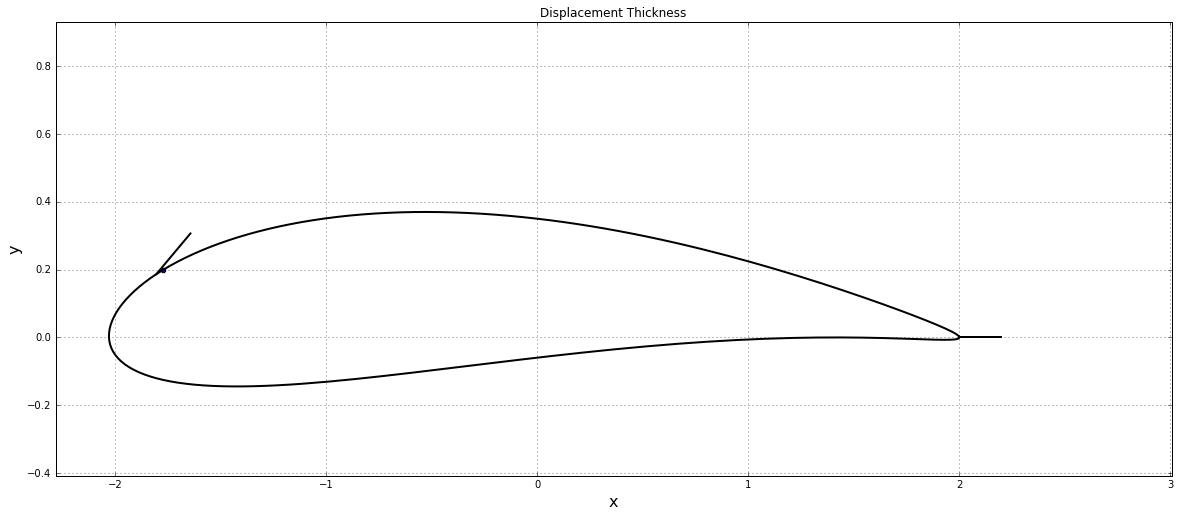

In [42]:
tr_x,tr_y = [DW_panel[1].xa,DW_panel[1].xb],[DW_panel[1].ya,DW_panel[1].yb]
wa_x,wa_y = [DW_panel[0].xa,DW_panel[0].xb],[DW_panel[0].ya,DW_panel[0].yb]
valX,valY = 0.1,0.2
xmin,xmax = min([p.xa for p in panels]),max([p.xa for p in panels])-1.5
ymin,ymax = 1.5*min([p.ya for p in panels]),2*max([p.ya for p in panels])
xStart,xEnd = xmin-valX*(xmax-xmin),xmax+valY*(xmax-xmin)
yStart,yEnd = ymin-valY*(ymax-ymin),ymax+valY*(ymax-ymin)
size = 20
pyplot.figure(figsize=(size,(yEnd-yStart)/(xEnd-xStart)*size))
pyplot.grid(True)
pyplot.xlabel('x',fontsize=16)
pyplot.ylabel('y',fontsize=16)
pyplot.title('Displacement Thickness')
pyplot.xlim(xStart,xEnd+2)
pyplot.ylim(yStart,yEnd)
pyplot.plot(X_wing,Y_wing,'k-',linewidth=2)
pyplot.scatter(X_wing[TR],Y_wing[TR])
pyplot.plot(tr_x,tr_y,'k-',linewidth=2)
pyplot.plot(wa_x,wa_y,'k-',linewidth=2)

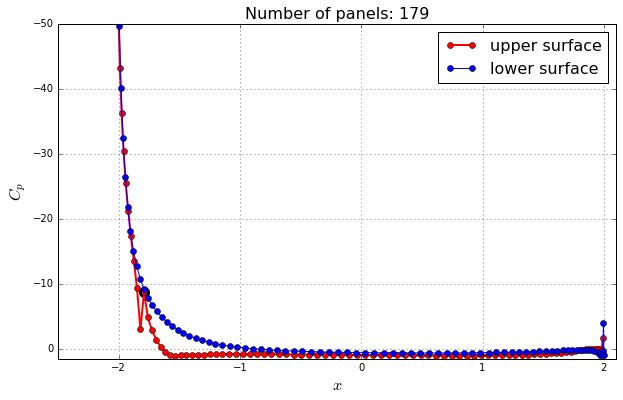

In [43]:
# plot surface pressure coefficient
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.scatter(panels[TR].xc,panels[TR].cp,color='k', s=100)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-2.5, 2.1)
pyplot.ylim(1.5, -50.0)
pyplot.title('Number of panels: {}'.format(panels.size), fontsize=16);

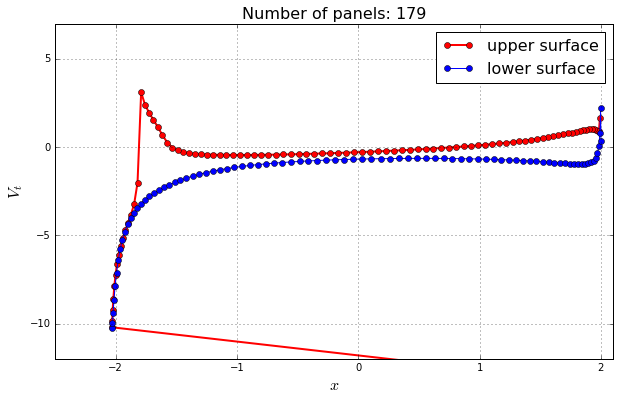

In [44]:
# plot surface tangential velocity
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$V_t$', fontsize=16)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.vt for panel in panels if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.vt for panel in panels if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)

pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-2.5, 2.1)
pyplot.ylim(-12,7)
pyplot.title('Number of panels: {}'.format(panels.size), fontsize=16);

From the plots above, it is shown that the there's a drop or jump for both the tangential velocity and pressure coefficient on the wing's surface just downstream the separation point. In this approach, it's caused by the vortex strength of the wake at the separation point, and in the practical situation, it is caused by the transition of the boundary layer from laminar to turbulent.